ETAPA 3: MODELO BASELINE - REGRESSÃO LINEAR (DELIVERY)

✓ Dados carregados: 2510 linhas, 17 colunas
  delivery_id  distance_km  package_weight_kg delivery_type vehicle_type  \
0    DEL00331        17.62              12.45       Express        Carro   
1    DEL02382        11.43               3.31       Economy        Carro   
2    DEL00825        25.87               2.79       Express        Carro   
3    DEL00336        14.21               6.99      Standard     Caminhão   
4    DEL00551        14.31                NaN      Standard          Van   

  traffic_condition        weather time_of_day day_of_week  \
0             Médio    Ensolarado       Tarde      domingo   
1             Médio     Ensolarado       Manhã     Seg-Qui   
2             Baixo     Ensolarado       Manhã     Seg-Qui   
3             Médio    Chuva Forte       Tarde     Domingo   
4              Alto        Nublado       Manhã      Sábado   

   driver_experience_years  num_stops is_priority package_fragile  \
0

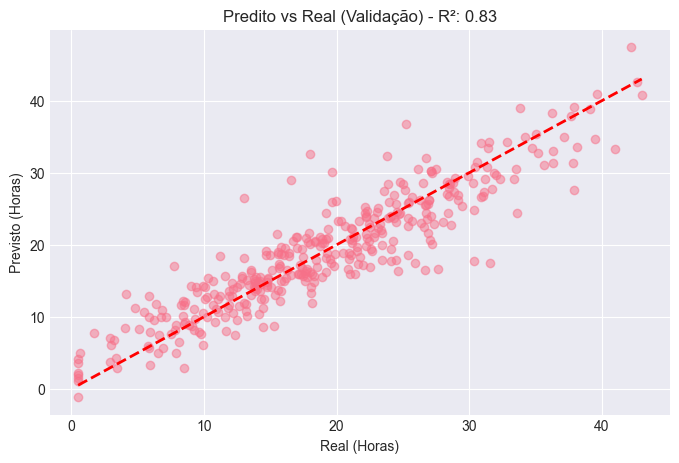

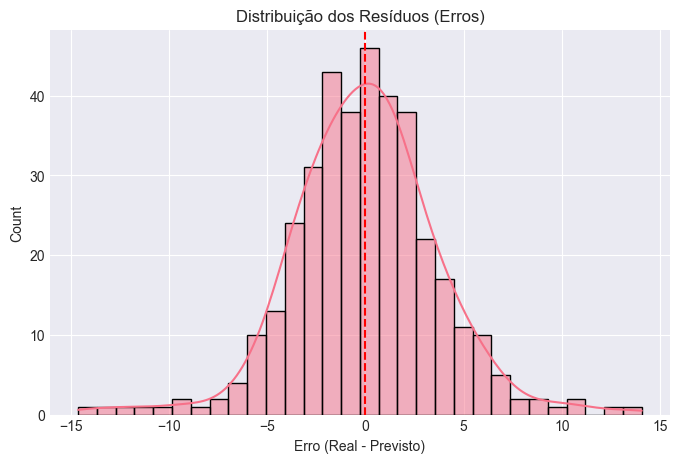


✓ Modelo salvo em ../models/baseline_model.pkl


In [3]:
# notebooks/03_Modelo_Baseline.ipynb

# ============================================================================
# 1. IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 2. CARREGAR DADOS LIMPOS
# ============================================================================
print("="*60)
print("ETAPA 3: MODELO BASELINE - REGRESSÃO LINEAR (DELIVERY)")
print("="*60)

# Caminho correto para o arquivo limpo gerado na Etapa 2
caminho_dados = '../data/processed/delivery_clean.csv'

if not os.path.exists(caminho_dados):
    print(f"⚠️ ARQUIVO NÃO ENCONTRADO: {caminho_dados}")
    print("Verifique se você rodou a Etapa 2 e salvou o CSV.")
else:
    df = pd.read_csv(caminho_dados)
    print(f"\n✓ Dados carregados: {df.shape[0]} linhas, {df.shape[1]} colunas")
    print(df.head())

# ============================================================================
# 3. SEPARAR FEATURES (X) e TARGET (y)
# ============================================================================

# Target do seu projeto de entrega
TARGET_COLUMN = 'delivery_time_hours' 

# Colunas que não são úteis para previsão (IDs, etc)
COLUNAS_REMOVER = ['delivery_id'] 

# Garantir que removemos apenas o que existe no df
cols_to_drop = [c for c in COLUNAS_REMOVER if c in df.columns] + [TARGET_COLUMN]

X = df.drop(columns=cols_to_drop, errors='ignore')
y = df[TARGET_COLUMN]

print(f"\n✓ Features (X): {X.shape[1]} colunas")
print(f"✓ Target (y): {y.shape[0]} valores")

# ============================================================================
# 3.5 CODIFICAR VARIÁVEIS CATEGÓRICAS
# ============================================================================
print("\n" + "="*60)
print("CODIFICANDO VARIÁVEIS CATEGÓRICAS")
print("="*60)

# Identificar colunas categóricas
colunas_categoricas = X.select_dtypes(include=['object']).columns.tolist()
print(f"Colunas categóricas encontradas: {colunas_categoricas}")

# Usar One-Hot Encoding
if len(colunas_categoricas) > 0:
    X = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)
    print(f"✓ One-Hot Encoding aplicado!")
    print(f"✓ Novas features (X): {X.shape[1]} colunas")

print(X.dtypes)

# ============================================================================
# 3.6 TRATAR VALORES FALTANTES (NaN)
# ============================================================================
print("\n" + "="*60)
print("TRATANDO VALORES FALTANTES")
print("="*60)

# Verificar NaN
print(f"NaN por coluna:\n{X.isnull().sum()}")
print(f"\nTotal de NaN: {X.isnull().sum().sum()}")

# Opção 1: Remover linhas com NaN
if X.isnull().sum().sum() > 0:
    print("Removendo linhas com valores faltantes...")
    X = X.dropna()
    y = y[X.index]  # Sincronizar y com X
    print(f"✓ Após remoção: {X.shape[0]} linhas")

# Opção 2 (alternativa): Preencher com média (descomente se preferir)
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"✓ NaN remanescentes: {X.isnull().sum().sum()}")

# ============================================================================
# 4. DIVISÃO DOS DADOS (60% TREINO / 20% VALIDAÇÃO / 20% TESTE)
# ============================================================================
RANDOM_STATE = 42

# 1. Separar 20% para TESTE (Guardar no cofre!)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# 2. Separar 25% do restante para VALIDAÇÃO (25% de 80% = 20% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)

print("\n" + "="*60)
print("DIVISÃO DOS DADOS")
print("="*60)
print(f"Total: {len(X)}")
print(f"├─ Treino:     {len(X_train)} (60%)")
print(f"├─ Validação:  {len(X_val)} (20%)")
print(f"└─ Teste:      {len(X_test)} (20%) - NÃO USAR AGORA!")

# ============================================================================
# 5. TREINAR MODELO BASELINE
# ============================================================================
print("\n" + "="*60)
print("TREINAMENTO")
print("="*60)

modelo = LinearRegression()
modelo.fit(X_train, y_train)
print("✓ Modelo de Regressão Linear treinado!")

# Analisar os coeficientes (O que mais impacta a entrega?)
coeficientes = pd.DataFrame({
    'Feature': X_train.columns,
    'Coeficiente': modelo.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

print("\nTop 5 Variáveis Mais Impactantes:")
print(coeficientes.head(5).to_string(index=False))

# ============================================================================
# 6. AVALIAÇÃO E MÉTRICAS
# ============================================================================
# Previsões
y_train_pred = modelo.predict(X_train)
y_val_pred = modelo.predict(X_val)

def calcular_metricas(y_true, y_pred, nome):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

metricas_train = calcular_metricas(y_train, y_train_pred, "Treino")
metricas_val = calcular_metricas(y_val, y_val_pred, "Validação")

# Exibir Comparação
print("\n" + "="*60)
print("RESULTADOS (Treino vs Validação)")
print("="*60)
df_metricas = pd.DataFrame([metricas_train, metricas_val], index=['Treino', 'Validação'])
print(df_metricas.round(4))

# Análise de Overfitting (R²)
diff_r2 = abs(df_metricas.loc['Treino', 'R²'] - df_metricas.loc['Validação', 'R²'])
print(f"\n📊 Análise de Overfitting (Diferença R²): {diff_r2:.4f}")
if diff_r2 < 0.10:
    print("✅ SUCESSO: O modelo generaliza bem (sem overfitting grave).")
else:
    print("⚠️ ATENÇÃO: Sinal de overfitting (diferença > 0.10).")

# ============================================================================
# 7. VISUALIZAÇÕES
# ============================================================================
print("\nGerando gráficos...")

# Gráfico 1: Predito vs Real
plt.figure(figsize=(8, 5))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Real (Horas)')
plt.ylabel('Previsto (Horas)')
plt.title(f'Predito vs Real (Validação) - R²: {metricas_val["R²"]:.2f}')
plt.savefig('../models/predicoes_vs_real.png')
plt.show()

# Gráfico 2: Resíduos
residuos = y_val - y_val_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuos, kde=True, bins=30)
plt.axvline(0, color='r', linestyle='--')
plt.title('Distribuição dos Resíduos (Erros)')
plt.xlabel('Erro (Real - Previsto)')
plt.savefig('../models/residuos.png')
plt.show()

# ============================================================================
# 8. SALVAR MODELO
# ============================================================================
os.makedirs('../models', exist_ok=True)
joblib.dump(modelo, '../models/baseline_model.pkl')
print("\n✓ Modelo salvo em ../models/baseline_model.pkl")